In [1]:
from __future__ import division
from pylab import *             # includes numpy

import scipy.io

from scipy.optimize import minimize # for fitting

from scipy.interpolate import NearestNDInterpolator

from numpy.random import normal

import json

from time import time
from copy import deepcopy

import nestpy

In [2]:
version_textbox = " NEST v{0} \n nestpy v{1}".format(nestpy.__nest_version__, nestpy.__version__)
bbox = dict(boxstyle="round", fc="1.00", edgecolor='none')


In [3]:
# for in-line figure:
%matplotlib inline

font = {'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

params = {'mathtext.default': 'regular','figure.figsize' : (10.0, 6.0) }          
matplotlib.rcParams.update(params)


fontsize=18


In [4]:
with open('ER_yields_data.dat','r') as f:
    d=json.load(f) 

## Print out the available datasets

In [5]:
for key in d.keys():
    print(key)

Baudis_2013
XeLDA_3H
XeLDA_Xe127
Aprile_2013
LUX_postWS_14C
LUX_postWS_3H
LUX_WS2013_3H
Dahl_thesis
Xe100_3H
neriX_Compton
LUX_WS2013_127Xe_a
LUX_WS2013_127Xe_b
Shanghai_Compton
Akimov
PIXeY_37Ar
Doke_976
Xe100_PE
Manalaysay_2010
Aprile_2006_PA
Aprile_2005_PA
Yamashita_2004
Aprile_2007_PE
pandaX_PE
Xenon1t_PA
LUX_PA


## Examine the LUX WS2013 tritium data

In [6]:
dname='LUX_WS2013_3H'
for key in d[dname].keys():
    print(key)

DOI
label
data
interaction_type
mcolor
mstyle
msize


Each datasat includes: 
* the DOI of the reference paper
* the interaction type
* some plotting format information
* the data 

## Now we inspect the data entry in LUX_WS2013_3H

In [7]:
for key in d['LUX_WS2013_3H']['data'].keys():
    print(key)

105_Vcm
180_Vcm


The 'data' entry for each dataset is subdivided by the fields at which the results were measured. For the LUX WS2013 tritium data this was 105 V/cm and 180 V/cm

## Inspect the actual data contained at in the '180_Vcm' field value



In [8]:
for key in d['LUX_WS2013_3H']['data']['105_Vcm'].keys():
    print(key,': ',d['LUX_WS2013_3H']['data']['105_Vcm'][key])

field :  105
field_pm :  20.0
energy :  [1.3, 2.2, 3.1, 4.0, 4.9, 5.8, 6.7, 7.6, 8.5, 9.4, 10.3, 11.2, 12.1, 13.0, 13.9, 15.0]
energy_pm :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
QY :  [54.6, 47.8, 39.6, 35.4, 33.1, 31.6, 29.9, 28.9, 26.8, 26.8, 25.3, 26.2, 23.9, 23.4, 22.2, 23.7]
QY_pm_sys :  [1.7, 1.9, 2.2, 2.3, 1.7, 2.2, 2.0, 1.6, 2.0, 2.0, 1.5, 1.5, 1.9, 1.5, 3.2, 1.4]
QY_pm_stat :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
fitting_weight :  10.0


In [9]:
for key in d['LUX_WS2013_3H']['data']['180_Vcm'].keys():
    print(key,': ',d['LUX_WS2013_3H']['data']['180_Vcm'][key])

field :  180
field_pm :  20.0
energy :  [1.3, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.2, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
energy_pm :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
QY :  [58.4, 55.7, 50.7, 45.6, 41.4, 39.2, 37.2, 35.5, 34.6, 34.1, 33.5, 32.6, 31.3, 31.3, 30.3, 30.1, 29.1, 28.3, 27.6, 27.0, 26.5, 25.9]
QY_pm_sys :  [2.2, 1.9, 2.4, 2.5, 2.3, 2.0, 2.2, 2.0, 1.9, 2.0, 2.1, 2.0, 2.0, 1.7, 2.0, 1.9, 1.7, 2.0, 1.7, 1.7, 1.5, 1.6]
QY_pm_stat :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
fitting_weight :  10.0


A few notes:
* The entries including '_pm' are uncertainties.
* Some datasets have asymmetric uncertainties. These are stored in 2xN lists
* The 'fitting_weight' entry is used to instruct the fitting code how strongly you want to weight that specific subset of data. This is probably not the best place for this variable. Currently the only dataset that isn't 1 should be the LUX WS2013 tritium, which is set to 10

In [10]:
d['LUX_WS2013_3H']['data']['180_Vcm']['fitting_weight']

10.0

## The functions in 'ER_fitting_tools.py' can be accessed using:

In [11]:
from ER_fitting_tools import *

## Plot all of the available data between 150 and 200 V/cm field

In [12]:
import nestpy
nestpy.__version__

'1.3.0'

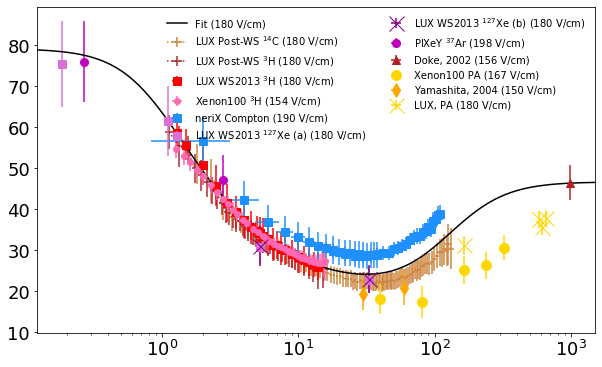

In [13]:


ax=subplot(111)
plot_field_range(ax,d,150,200)

xscale('log')

field=180
xmin, xmax = ax.get_xlim()
xx=10**linspace(log10(xmin),log10(xmax),100)
xlim(xmin,xmax)

#plot NESTv2 beta model at 180 V/cm
b0=NESTv2_parms()
yy=NESTv2_QY(xx,field,*b0)
plot(xx,yy,'k-',label='Fit ('+str(int(field))+' V/cm)')

legend(frameon=False,fontsize=10,ncol=2)

## Running a global minimization on the combined Compton/beta model
### First, we want to skip any photoabsorption datasets

In [14]:
skip_sets=[]
for dname in d.keys():
    if (
        (d[dname]['interaction_type']=='photoabsorption')
    ):
        for fname in d[dname]['data'].keys():
            skip_sets.append(dname+': '+fname)
            
skip_sets

['Xe100_PE: 100_Vcm',
 'Xe100_PE: 167_Vcm',
 'Xe100_PE: 400_Vcm',
 'Xe100_PE: 500_Vcm',
 'Xe100_PE: 530_Vcm',
 'Manalaysay_2010: 98_Vcm',
 'Manalaysay_2010: 147_Vcm',
 'Manalaysay_2010: 371_Vcm',
 'Aprile_2006_PA: 95_Vcm',
 'Aprile_2006_PA: 142_Vcm',
 'Aprile_2006_PA: 392_Vcm',
 'Aprile_2005_PA: 96_Vcm',
 'Yamashita_2004: 96_Vcm',
 'Yamashita_2004: 150_Vcm',
 'Yamashita_2004: 400_Vcm',
 'Aprile_2007_PE: 104_Vcm',
 'pandaX_PE: 400_Vcm',
 'Xenon1t_PA: 119_Vcm',
 'LUX_PA: 180_Vcm']

## Define the bounds on the fitting parameters

In [15]:
bounds=(
    (60,90),#plow0
    (0,10),#plow1
    (0,100),#plow2
    (0,5),#plow3
    (0,100),#pmed1
    (0,1),#pmed2
    (0,10),#pmed3
    (0,10),#pmed4
    (0,100),#QyLvlhighE
    (0,10000),#pDB1
    (1e10,1e11),#pDB2
    (0,5),#pDB3
    (0,5),#pDB4
    (0,5),#m3
    (0,5),#m4
    (0,5),#m9
     )

In [16]:
res=minimize(lambda p: min_func(p,d,NESTv2_QY,skip_sets=skip_sets)
            ,b0,
#             method='Nelder-Mead', 
#             method='TNC', 
#             method='SLSQP',
            options={'maxiter':100000},
            bounds=bounds

                )

/home/sophiaandaloro/nest/ER_data/ER_fitting_tools.py:331: RuntimeWarning: divide by zero encountered in double_scalars
  QyLvlmedE =pmed1-pmed1/(1.+pow(dfield/(pmed2*exp(density/pmed3)),pmed4));
/home/sophiaandaloro/nest/ER_data/ER_fitting_tools.py:331: RuntimeWarning: overflow encountered in exp
  QyLvlmedE =pmed1-pmed1/(1.+pow(dfield/(pmed2*exp(density/pmed3)),pmed4));


KeyboardInterrupt: 

### Check for convergence

In [17]:
print(res['message'])

b'ABNORMAL_TERMINATION_IN_LNSRCH'


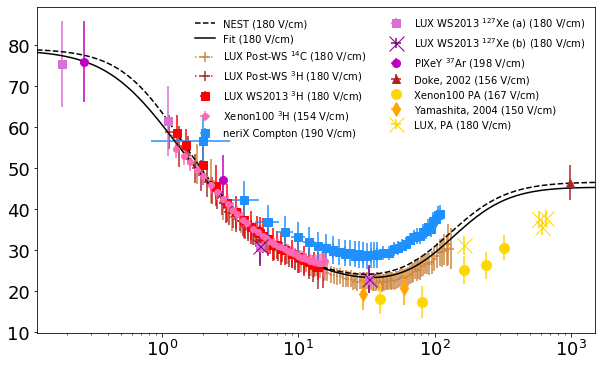

In [18]:
ax=subplot(111)
plot_field_range(ax,d,150,200)

xscale('log')

field=180
xmin, xmax = ax.get_xlim()
xx=10**linspace(log10(xmin),log10(xmax),100)
xlim(xmin,xmax)
yy=NESTv2_QY(xx,field,*b0)
plot(xx,yy,'k--',label='NEST ('+str(int(field))+' V/cm)')

yy=NESTv2_QY(xx,field,*res['x'])
plot(xx,yy,'k-',label='Fit ('+str(int(field))+' V/cm)')

legend(frameon=False,fontsize=10,ncol=2)

In [17]:
@np.vectorize
def GetYieldsVectorized(interaction, yield_type, **kwargs):
    yield_object = nc.GetYields(interaction = interaction, **kwargs)
    # returns the yields for the type of yield we are considering 
    return getattr(yield_object, yield_type)

def PhotonYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'PhotonYield', **kwargs)
 
def ElectronYield(**kwargs):
    return GetYieldsVectorized(yield_type = 'ElectronYield', **kwargs)

# def Yield(**kwargs):
#     return {'photon' : PhotonYield(**kwargs),
#             'electron' : ElectronYield(**kwargs),
#            # What is missing?  Aren't there other parts of YieldObject?
#            }

In [18]:
nr_energy = np.asarray([6.896925857,
9.476535847,
12.07362603,
14.48470129,
16.8042268,
19.28930739,
21.55198533,
23.81931702,
26.15537406,
28.25737067,
31.3999267,
35.57804538,
39.77735513,
43.87378001,
49.72308321,
56.5,
57.52839915,
65.03887601,
75.76087412])

nr_qy = np.asarray([5.652026851,
5.2916775,
4.934439282,
4.71369506,
4.581954843,
4.413410838,
4.288910172,
4.147680288,
4.004200575,
3.971099867,
3.84822342,
3.679793419,
3.564968221,
3.419075624,
3.264760899,
3.205884941,
3.093550591,
2.850751538,
2.700349801]) # Already scaled, yields/keV! 


#Detector identification
detector = nestpy.DetectorExample_XENON10()
# detector = nestpy.VDetector()
# Performing NEST calculations according to the given detector example       
nc = nestpy.NESTcalc(detector) #can also be left empty    

#GetInteractionObject grabs the number for the interaction you want so you don't have to always reference the dictionary. Just type e.g., 'ion'
#It just changes the name to a number for nestpy to do its work.

In [19]:
fields=np.asarray([81.])
energies = np.logspace(-1, 3, 1000,)
energies = np.reshape(energies, (1000,1))
energies = np.broadcast_to(energies, (len(energies), len(fields)))

kwargs = {'energy': energies, 'drift_field': fields}
beta_electrons = ElectronYield(interaction=nestpy.INTERACTION_TYPE.beta, **kwargs)/energies #yields/keV
gamma_electrons = ElectronYield(interaction=nestpy.INTERACTION_TYPE.gammaRay, **kwargs)/energies
nr_electrons = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies
beta_photons = PhotonYield(interaction=nestpy.INTERACTION_TYPE.beta, **kwargs)/energies #yields/keV
gamma_photons = PhotonYield(interaction=nestpy.INTERACTION_TYPE.gammaRay, **kwargs)/energies
nr_photons = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)/energies


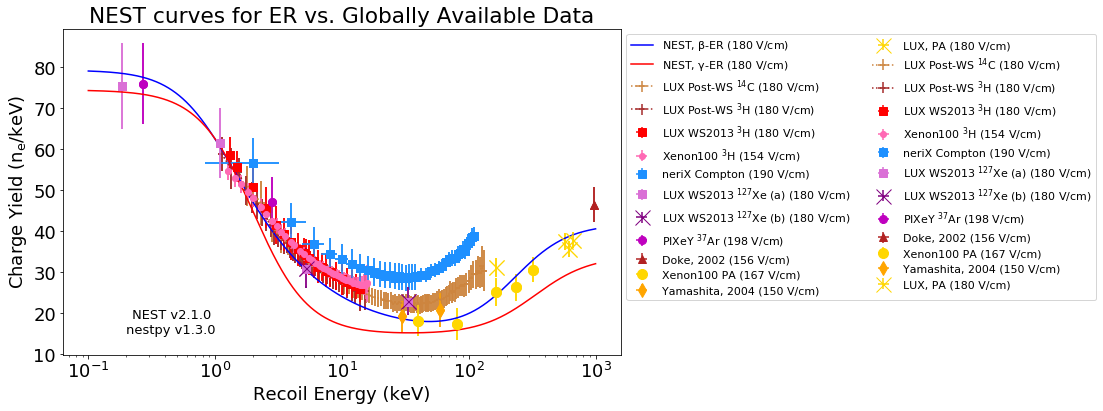

In [23]:
plt.figure()
ax=subplot(111)
plot_field_range(ax,d,150,200)
plt.plot(energies, beta_electrons, 'b', label=r'NEST, $\beta$-ER (180 V/cm)')
plt.plot(energies, gamma_electrons, 'r', label=r'NEST, $\gamma$-ER (180 V/cm)')
plt.text(1, 15, 
                version_textbox, 
                bbox=bbox, horizontalalignment='right', fontsize=13)
plot_field_range(ax,d,150,200)
# plt.xlim((1e0,30))
plt.xscale('log')
# legend(frameon=False,fontsize=10,ncol=2, )
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=2, fontsize=11)
plt.title("NEST curves for ER vs. Globally Available Data", fontsize='large')
plt.xlabel("Recoil Energy (keV)")
plt.ylabel("Charge Yield ($n_{e}$/keV)")
plt.savefig('global_er.png')
plt.show()

In [19]:
fields=np.asarray([81.])
energies = np.logspace(-1, 3, 1000,)
energies = np.reshape(energies, (1000,1))
energies = np.broadcast_to(energies, (len(energies), len(fields)))

kwargs = {'energy': energies, 'drift_field': fields}
beta_electrons = ElectronYield(interaction=nestpy.INTERACTION_TYPE.beta, **kwargs) #yields/keV
gamma_electrons = ElectronYield(interaction=nestpy.INTERACTION_TYPE.gammaRay, **kwargs)
nr_electrons = ElectronYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)
beta_photons = PhotonYield(interaction=nestpy.INTERACTION_TYPE.beta, **kwargs) #yields/keV
gamma_photons = PhotonYield(interaction=nestpy.INTERACTION_TYPE.gammaRay, **kwargs)
nr_photons = PhotonYield(interaction=nestpy.INTERACTION_TYPE.NR, **kwargs)


In [20]:
scatter_energies = np.asarray([.6, 1, 2, 3, 5, 10, 20, 50])


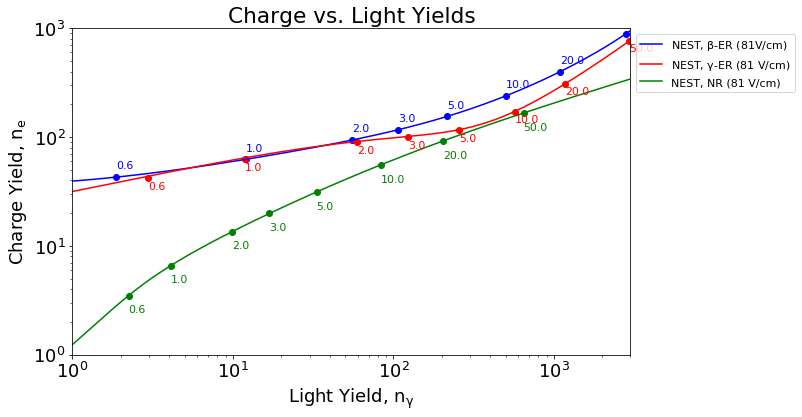

In [23]:
plt.figure()
plt.plot(beta_photons, beta_electrons, 'b', label=r'NEST, $\beta$-ER (81V/cm)')
plt.plot(gamma_photons, gamma_electrons+2, 'r', label=r'NEST, $\gamma$-ER (81 V/cm)')
plt.plot(nr_photons, nr_electrons, 'g', label=r'NEST, NR (81 V/cm)')
plt.scatter(PhotonYield(interaction = nestpy.INTERACTION_TYPE.beta, energy=scatter_energies, drift_field=fields), ElectronYield(interaction = nestpy.INTERACTION_TYPE.beta, energy=scatter_energies, drift_field=fields), c='b')
plt.scatter(PhotonYield(interaction = nestpy.INTERACTION_TYPE.gammaRay, energy=scatter_energies, drift_field=fields), ElectronYield(interaction = nestpy.INTERACTION_TYPE.gammaRay, energy=scatter_energies, drift_field=fields), c='r')
plt.scatter(PhotonYield(interaction = nestpy.INTERACTION_TYPE.NR, energy=scatter_energies, drift_field=fields), ElectronYield(interaction = nestpy.INTERACTION_TYPE.NR, energy=scatter_energies, drift_field=fields), c='g')
for scatter_energy in scatter_energies:
    plt.annotate(scatter_energy, (PhotonYield(interaction = nestpy.INTERACTION_TYPE.NR, energy=scatter_energy, drift_field=fields), ElectronYield(interaction = nestpy.INTERACTION_TYPE.NR, energy=scatter_energy, drift_field=fields)*.7), c='g', fontsize=11)
    plt.annotate(scatter_energy, (PhotonYield(interaction = nestpy.INTERACTION_TYPE.gammaRay, energy=scatter_energy, drift_field=fields), ElectronYield(interaction = nestpy.INTERACTION_TYPE.gammaRay, energy=scatter_energy, drift_field=fields)*.8), c='r', fontsize=11)
    plt.annotate(scatter_energy, (PhotonYield(interaction = nestpy.INTERACTION_TYPE.beta, energy=scatter_energy, drift_field=fields), ElectronYield(interaction = nestpy.INTERACTION_TYPE.beta, energy=scatter_energy, drift_field=fields)*1.2), c='b', fontsize=11)

plt.xlabel(r'Light Yield, $n_{\gamma}$')
plt.ylabel(r'Charge Yield, $n_{e}$')
plt.xscale('log')
plt.xlim((1e0,3e3))
plt.ylim((1e0, 1e3))
plt.yscale('log')

plt.title('Charge vs. Light Yields')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize=11)


In [30]:
W = .0137 # kev/quanta

def ly(qy, energy):
    ly = energy/W - qy
    return ly

In [29]:
nestpy.

-661.92700729927